This is an expiremental notebook where you can specify a dataframe path and see how fastText performs on the dataset.

The dataset will remove issues made by detected bots, and additional bots can be added as well. 

Each label is predicted as a fastText binary classification task. Negative samples are evenly distributed amongst other labels.

The output will be a dataframe with the precision, accuracy, and recall for each label, computed using k-fold cross validation.

In [125]:
import pandas as pd
import numpy as np
from skift import FirstColFtClassifier
import itertools
import collections
import os
import seaborn as sns
from sklearn.model_selection import KFold
import boto3
from dotenv import load_dotenv, find_dotenv
import sys

sys.path.append("../src/data")
from preprocess import process

In [38]:
# load environment variables
load_dotenv(find_dotenv())

True

In [39]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [40]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [41]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

savename = USER if USER else REPO.replace("/", "-_-")
path = os.path.join("../data", savename + ".csv")
key = f"github-labeler/data/{savename}.csv"

if use_ceph:
    print(key)
    response = s3.get_object(Bucket=s3_bucket, Key=key)
    issues_df = pd.read_csv(response.get("Body")).drop_duplicates()
else:
    issues_df = pd.read_csv(path).drop_duplicates()

In [42]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
3949,openshift/origin/10157,openshift/origin,oc delete all --all does not delete deployment...,@deads2k @fabianofranz I think we want to add ...,2016-08-02 09:43:27,mfojtik,4,component/cli\tcomponent/kubernetes\tlifecycle...
261,openshift/origin/1342,openshift/origin,Oauth server not handling state when requestin...,This results in the web console not returning ...,2015-03-17 20:27:23,jwforres,3,component/web\tkind/bug\tpriority/P2
5747,openshift/origin/12017,openshift/origin,TestBuildRunningPodDeleteController flake,Seen [here](https://ci.openshift.redhat.com/je...,2016-11-23 21:31:26,stevekuznetsov,3,component/build\tkind/test-flake\tpriority/P2
7854,openshift/origin/17183,openshift/origin,An error occurred creating the route,## oc version\r\n\r\noc v3.6.173.0.5\r\nkubern...,2017-11-04 17:20:27,syui,3,component/networking\tkind/bug\tpriority/P2
5824,openshift/origin/12253,openshift/origin,oadm top images -n <namespace> list the all th...,[provide a description of the issue]\r\noadm t...,2016-12-14 06:03:39,wanghaoran1988,4,component/cli\tcomponent/image\tkind/bug\tprio...


In [43]:
# output most popular labels

cutoff = 50

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")

priority/P2 3510
kind/bug 1868
lifecycle/rotten 1788
priority/P3 1388
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 749
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 486
component/kubernetes 392
component/imageregistry 324
component/networking 323
lifecycle/stale 308
component/auth 299
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 174
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 115
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52


In [44]:
# define synonyms, first in set will be used name

synsets = [
    ["kind/bug", "bug"],
]

In [45]:
# equate synonyms

for syn in synsets:

    def equate_syns(lbl):
        return syn[0] if lbl in syn[1:] else lbl

    def equate_list(lbllist):
        if type(lbllist) == str:
            return "\t".join(
                list(set([equate_syns(lbl) for lbl in lbllist.split("\t")]))
            )
        else:
            return lbllist

    issues_df.labels = issues_df.labels.apply(equate_list)

(0.0, 6.0)

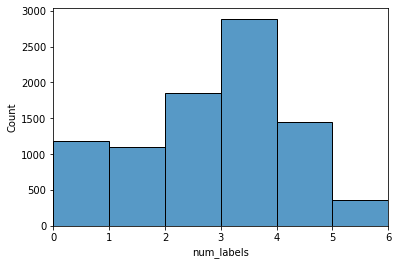

In [46]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [47]:
# view most common issue creators

issues_df.created_by.value_counts(ascending=False).head(10)

smarterclayton    768
deads2k           374
kargakis          362
spadgett          349
bparees           297
liggitt           276
stevekuznetsov    273
mfojtik           256
soltysh           139
sosiouxme         108
Name: created_by, dtype: int64

In [48]:
# first find bots transparently tagged as such


def is_bot(name):
    return name[-5:] == "[bot]"


all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print("bots found:")
for b in bots:
    print("\t", b)

bots found:


In [49]:
# choose any additional bot accounts whose issues to not count

additional_bots = ["sesheta"]

In [50]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]

In [51]:
# most popular labels, nearly finalized

cutoff = 50
final_labels = []

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")
        final_labels.append(a)

priority/P2 3510
kind/bug 1868
lifecycle/rotten 1788
priority/P3 1388
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 749
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 486
component/kubernetes 392
component/imageregistry 324
component/networking 323
lifecycle/stale 308
component/auth 299
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 174
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 115
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52


In [52]:
# choose labels whose issues you don't want to include in the dset

exclude = []

In [53]:
# remove those labels

for lbl in exclude:
    if lbl in final_labels:
        final_labels.remove(lbl)


def inclusion(lbl_list):
    if type(lbl_list) == str:
        return not any([lbl in lbl_list.split("\t") for lbl in exclude])
    else:
        return True


not_containing = issues_df.labels.apply(lambda x: inclusion(x))
issues_df = issues_df[not_containing]

In [54]:
# choose issues you do not wish to attempt to predict

dont_pred = [
    "priority/P2",
    "lifecycle/frozen",
    "lifecycle/stale",
    "priority/P3",
    "priority/P1",
    "lifecycle/rotten",
]

for dp in dont_pred:
    if dp in final_labels:
        final_labels.remove(dp)
    else:
        continue

(0.0, 6.0)

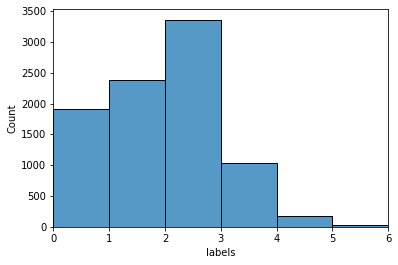

In [55]:
# output histogram of number of relevant labels, finalized

set_dp = set(dont_pred)

num_rel_issues = issues_df.labels.apply(
    lambda x: len(set(x.split("\t")).difference(set_dp)) if type(x) == str else 0
)

ax = sns.histplot(num_rel_issues, bins=int(max(num_rel_issues)))
ax.set_xlim((0, 6))

In [56]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    labelled = issues_df[~issues_df.labels.isna()]
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labelled[labelled.labels.apply(lambda x: label in x.split("\t"))]
    n = len(pos_samples)
    remaining = labelled[labelled.id.apply(lambda x: label not in x.split("\t"))]
    n_neg = 0
    per_label = n // len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining[remaining.labels.apply(lambda x: lbl in x.split("\t"))]
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            if i != len(final_labels_) - 1:
                per_label = (n - n_neg) // (len(final_labels_) - i - 1)
        remaining = remaining[
            remaining.labels.apply(lambda x: lbl not in x.split("\t"))
        ]
        neg_ids = neg_ids.union(set(neg_samples.id))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_samples) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_samples) - len(neg_ids):
            neg_ids = neg_ids.union(
                set(unlabelled.sample(len(pos_samples) - len(neg_ids)).id)
            )
        else:
            neg_ids = neg_ids.union(set(unlabelled.ids))
            pos_samples = pos_samples.sample(len(neg_ids))
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)]
    x = pd.concat((final_neg_samples, pos_samples))
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(pos_samples))))
    return x, y.astype(int)

In [57]:
x, y = get_subdataset("kind/question")

In [58]:
x

,id,repo,title,body,created_at,created_by,num_labels,labels
1,openshift/origin/17,openshift/origin,Switch to Godeps,Upstream has integrated Godeps - we need to ha...,2014-08-13 23:04:15,smarterclayton,0,NaN
4,openshift/origin/69,openshift/origin,Client and Registry should take and return poi...,Going to be consistent with upstream. @ncdc y...,2014-09-10 03:08:07,smarterclayton,0,NaN
86,openshift/origin/512,openshift/origin,Refactor Router Plugins,Currently the factoring of the Router and Plug...,2014-12-02 21:07:46,pmorie,0,NaN
146,openshift/origin/818,openshift/origin,Jenkins merge queue is not flagging gofmt errors,"Travis is, Jenkins is not, Jenkins should. Po...",2015-01-31 17:27:37,smarterclayton,1,kind/bug
161,openshift/origin/887,openshift/origin,Starting node with --kubeconfig still uses aut...,Run `openshift start node --kubeconfig=/opensh...,2015-02-04 21:34:14,liggitt,1,kind/bug
...,...,...,...,...,...,...,...,...
10169,openshift/origin/22681,openshift/origin,why template nodejs-mongodb.json is not merged...,"Hi,\r\n\r\nthis is not concerning any issue, o...",2019-04-26 11:08:37,idavollen,3,component/build\tkind/question\tarea/examples
10298,openshift/origin/23721,openshift/origin,How to access default image registry in OpenSh...,<!--\r\nNote that this is the issue tracker fo...,2019-09-03 23:39:32,Piping,3,kind/question\tcomponent/imageregistry\tsig/de...
10393,openshift/origin/24345,openshift/origin,Allow server to parse empty strings,### Version\r\n4.2\r\n\r\n##### Steps To Repro...,2019-12-23 16:23:15,Gl4di4torRr,1,kind/question
10427,openshift/origin/24539,openshift/origin,Problem with pull images from registry.redhat....,"We, RHSCL team, would like to test our contain...",2020-02-14 11:32:32,phracek,2,component/build\tkind/question


In [120]:
class FT_Model(FirstColFtClassifier):
    
    def __init__(self):
        super().__init__()
        
    def preprocess(self, x):
        ret = np.array(x.apply(lambda row: ' '.join(process(row['title'], row['body'])),axis = 1)).reshape(-1, 1)
        return ret 
    
    def fit(self, x, y):
        input_ = self.preprocess(x)
        super().fit(input_, y)
    
    def predict(self, x):
        input_ = self.preprocess(x)
        return super().predict(input_)
    
class SVM()

In [121]:
def predict_label(label, k=5, model_class=FT_Model_2):
    """
    validates fastText model on the given label, using k-fold cross validation
    """
    x, y = get_subdataset(label)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    accuracy = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(x):
        model = model_class()
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        accuracy.append(np.mean(preds == y_test))
        precision_ = preds[preds == 1] == y_test[preds == 1]
        if len(precision_) != 0:
            precision.append(np.mean(precision_))
        recall_ = preds[y_test == 1] == y_test[y_test == 1]
        if len(recall_) != 0:
            recall.append(np.mean(recall_))
    cols = ["label", "n", "accuracy", "precision", "recall"]
    data = [label, len(x), np.mean(accuracy), np.mean(precision), np.mean(recall)]
    return pd.DataFrame([data], columns=cols)

In [122]:
predicted_labels = []
for label in final_labels:
    predicted_labels.append(predict_label(label))

/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NOTE: for now, labels with a low amount of samples are very biased towards predicting a 0, or a negative prediction. This could be fixed by adjusting hyperparameters (once they are explored) and/or finetuning on a pretrained model.

In [123]:
# save and print the validation results

results_df = pd.concat(predicted_labels).sort_values("n", ascending=False)

results_df

,label,n,accuracy,precision,recall
0,kind/bug,3736,0.600911,0.583452,0.714979
0,kind/test-flake,2170,0.805991,0.835423,0.768145
0,component/cli,1746,0.733662,0.715494,0.789376
0,kind/question,1498,0.686234,0.647685,0.833569
0,area/usability,1310,0.667176,0.676466,0.630163
0,component/build,1296,0.764672,0.751994,0.806914
0,component/web,1274,0.796711,0.801995,0.793560
0,area/tests,1198,0.806374,0.788504,0.838450
0,component/apps,972,0.775813,0.900657,0.633241
0,component/kubernetes,784,0.559979,0.640641,0.431436


In [124]:
# set conditions for saving the model of a potential label

min_accuracy = 0.55

min_precision = 0.6

min_recall = 0.0

# add in the labels you want to have a model for anyway

# addins = ['kind/bug', 'kind/feature']

addins = []

condition1 = results_df.accuracy > min_accuracy
condition2 = results_df.precision > min_precision
cond = condition1 & condition2

to_save = results_df[cond | results_df.label.isin(addins)]

labels_to_save = to_save.label.values

to_save

,label,n,accuracy,precision,recall
0,kind/test-flake,2170,0.805991,0.835423,0.768145
0,component/cli,1746,0.733662,0.715494,0.789376
0,kind/question,1498,0.686234,0.647685,0.833569
0,area/usability,1310,0.667176,0.676466,0.630163
0,component/build,1296,0.764672,0.751994,0.806914
0,component/web,1274,0.796711,0.801995,0.793560
0,area/tests,1198,0.806374,0.788504,0.838450
0,component/apps,972,0.775813,0.900657,0.633241
0,component/kubernetes,784,0.559979,0.640641,0.431436
0,component/imageregistry,648,0.746989,0.755910,0.834026


In [26]:
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")

if use_ceph:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = FirstColFtClassifier()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_") + ".bin")
        model.model.save_model(lbl_path)
        key = f"github_labeler/{lbl_path}"
        s3.upload_file(Bucket=s3_bucket, Key=key, Filename=lbl_path)
        os.remove(lbl_path)
else:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = FirstColFtClassifier()
        model.fit(X, y)
        model.model.save_model(
            os.path.join("saved_models", label.replace("/", "_") + ".bin")
        )

In [ ]:
# save information of who to ignore (so the app knows not to tag these issues)

with open("botlist.txt", "w") as f:
    for b in bots:
        f.write(b)
        f.write("\n")

# save label names

with open("labellist.txt", "w") as f:
    for b in labels_to_save:
        f.write(b)
        f.write("\n")

if use_ceph:
    s3.upload_file(
        Bucket=s3_bucket, Key="github_labeler/botlist.txt", Filename="botlist.txt"
    )
    s3.upload_file(
        Bucket=s3_bucket, Key="github_labeler/labellist.txt", Filename="labellist.txt"
    )